<a href="https://colab.research.google.com/github/timonpalm/TFCourse/blob/main/07_food_vision_milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf

# Check GPU

Not all GPU's are compatible with Mixture Learning. GPU needs to have a combuting factor equal or higher than 7.0.
So choose Tesla T4 GPU

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ca5246a9-08b1-bb3c-e476-4f7a7b66055b)


In [4]:
# Download helper function
# ! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-14 19:48:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-14 19:48:59 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


## Use Tensorflow Dataset to download data

In [7]:
# Get Tensorflow Datasets
import tensorflow_datasets as tfds

In [ ]:
datasets_list = tfds.list_builders()
datasets_list

In [11]:
# Load in the data (takes 506 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete841DM4/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete841DM4/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the data

In [12]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [13]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [17]:
train_one_sample = train_data.take(1)

In [18]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [19]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image sahpe: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image sahpe: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 16
  Class name: cheesecake
  


In [20]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [21]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Dataset

(-0.5, 511.5, 511.5, -0.5)

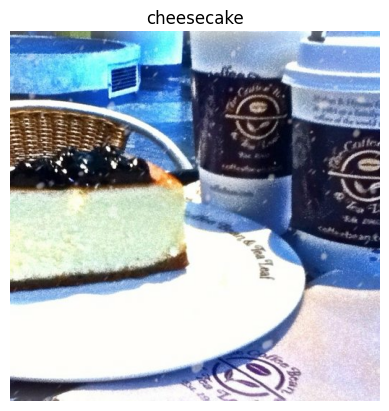

In [22]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [23]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [25]:
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 84.67857 ,  84.321434,  92.321434],
        [ 87.19898 ,  86.841835,  94.841835],
        [ 84.72959 ,  84.581635,  94.72449 ],
        ...,
        [119.50503 , 194.93877 , 245.85202 ],
        [114.974525, 190.97452 , 241.90309 ],
        [119.071465, 196.4286  , 247.82652 ]],

       [[ 75.647964,  84.21939 ,  93.21939 ],
        [ 71.45407 ,  80.959175,  89.959175],
        [ 78.03061 ,  87.20408 ,  97.47449 ],
        ...,
        [113.31632 , 182.62755 , 249.35715 ],
        [106.57655 , 176.86227 , 245.4337  ],
        [108.601944, 179.9796  , 248.16833 ]],

       [[129.9949  , 152.06633 , 171.4949  ],
        [149.87756 , 171.94899 , 192.66328 ],
        [156.43878 , 178.29593 , 201.22449 ],
        ...,
        [127.94895 , 184.08676 , 236.39796 ],
        [129.41847 , 186.4899  , 238.41847 ],
        [132.56607 , 191.07118 , 243.63744 ]],

       ...,

       [[ 68.23475 ,  72.091934,  90.73993 ],
        [ 67.